In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from collections import OrderedDict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import time
from IPython.core.magic import register_cell_magic
import gc
from torch.amp import autocast, GradScaler
from torchtnt.utils.data import CudaDataPrefetcher



@register_cell_magic
def skip(line, cell):
    return

device = 'cuda'


/home/super/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dl = False
data_path = './data'

# Load CIFAR-10 dataset with the simple transform
cifar10_train = datasets.CIFAR10(data_path, train=True, download=dl, transform=transforms.ToTensor())
try: 
    mean = torch.load('data/mean.pt')
    std = torch.load('data/std.pt')
except FileNotFoundError:
    print("Computing Mean and Std")
    train_imgs = torch.stack([img for img, _ in cifar10_train], dim=3)#.to(device=device)
    view = train_imgs.view(3, -1)#.to(device=device)

    mean = train_imgs.view(3, -1).mean(dim=1)
    std = train_imgs.view(3, -1).std(dim=1)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    torch.save(mean, 'data/mean.pt')
    torch.save(std, 'data/std.pt')

# Define the transform with normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
print("Mean: ", mean)
print("Std: ", std)
cifar10_train = datasets.CIFAR10(data_path, train=True, download=dl, transform=transform)
cifar10_test = datasets.CIFAR10(data_path, train=False, download=dl, transform=transform)

/tmp/ipykernel_850563/2313373535.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mean = torch.load('data/mean.pt')
/tmp/ipykernel_850563/2313373535.py:8: FutureWarning: 

Mean:  tensor([0.4914, 0.4822, 0.4465])
Std:  tensor([0.2470, 0.2435, 0.2616])


In [3]:

class Classifier(nn.Module):
    @classmethod
    def compare_results(cls, results1, results2):
        print('Comparing results:')
        comparisons = {
            'accuracy': 100*(results1['accuracy'] - results2['accuracy'])/results1['accuracy'],
            'precision': 100*(results1['precision'] - results2['precision'])/results1['precision'],
            'recall': 100*(results1['recall'] - results2['recall'])/results1['recall'],
            'f1': 100*(results1['f1'] - results2['f1'])/results1['f1']
        }
        for key, value in comparisons.items():
            print(f'{key}: {value} %')
        
    def __init__(self):
        super().__init__()
            
    def forward(self, x):
        return self.stack(x)
    def predict(self, x):
        with torch.no_grad():
            self.eval()
            return self.forward(x).argmax(dim=1)
    
    def train_model(
        self,
        epochs,
        train_loader,
        test_loader,
        train_len,
        test_len,
        test_size,
        loss_fn=nn.CrossEntropyLoss(),
        optimizer=torch.optim.SGD,
        optimizer_args = [],
        optimizer_kwargs = {},
        print_epoch=10,
        header_epoch = 15,
        sched_factor = 0.1,
    ):  
        
        scaler = GradScaler("cuda")
        optimizer = optimizer(self.parameters(), *optimizer_args, **optimizer_kwargs)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5, factor=sched_factor)
        training_time = 0
        train_hist = torch.zeros(epochs, device=device)
        test_hist = torch.zeros(epochs, device=device)
        accuracy_hist = torch.zeros(epochs, device=device)
        
        cell_width = 20
        header_form_spec = f'^{cell_width}'
        
        epoch_inspection = {
            "Epoch": 0,
            "Epoch Time (s)": 0,
            "Training Loss": 0,
            "Test Loss ": 0,
            "Overfit (%)": 0,
            "Accuracy (%)": 0,
            "Δ Accuracy (%)": 0,
            "GPU Memory (GiB)": 0
        }

        header_string = "|"
        for key in epoch_inspection.keys():
            header_string += (f"{key:{header_form_spec}}|")
        
        divider_string = '-'*len(header_string)
        if print_epoch:
            print(f'Training {self.__class__.__name__}\n')
            print(divider_string)
        max_accuracy = torch.zeros(1, device=device)            
        for epoch in range(epochs):
            begin_epoch = time.time()
            self.train()
            
            start_time = time.time()
            train_loss = 0
            for X_batch, Y_batch in train_loader:
                #X_batch, Y_batch = X_batch.to(device, non_blocking=True), Y_batch.to(device, non_blocking=True)
                optimizer.zero_grad(set_to_none=True)
                with autocast("cuda"):
                    Y_pred = self.forward(X_batch)
                    loss = loss_fn(Y_pred, Y_batch)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                
                train_loss += loss
            training_time += time.time() - start_time
            
            train_loss = train_loss/train_len
            train_hist[epoch] = train_loss
            
            
            self.eval()
            with torch.no_grad():
                test_loss = torch.zeros(1, device=device)
                correct = torch.zeros(1, device=device)               
                
                for X_test_batch, Y_test_batch in test_loader:
                    #X_test_batch, Y_test_batch = X_test_batch.to(device, non_blocking=True), Y_test_batch.to(device, non_blocking=True)
                    
                    out = self.forward(X_test_batch)
                    test_loss += loss_fn(out, Y_test_batch)
                    correct += (out.argmax(dim=1) == Y_test_batch).sum()
                    
            test_loss = test_loss/test_len
            test_hist[epoch] = test_loss
            accuracy = correct/test_size
            accuracy_hist[epoch] = accuracy
            
            scheduler.step(accuracy)
            
            end_epoch = time.time()
            if print_epoch and (epoch % print_epoch == 0 or epoch == epochs - 1) :
                mem = (torch.cuda.memory_allocated() + torch.cuda.memory_reserved())/1024**3
                if header_epoch and epoch % header_epoch == 0:
                    print(header_string)
                    print(divider_string)
                epoch_duration = end_epoch - begin_epoch
                overfit = 100 * (test_loss - train_loss) / train_loss
                d_accuracy = torch.zeros(1) if max_accuracy == 0 else 100 * (accuracy - max_accuracy) / max_accuracy
                if accuracy > max_accuracy:
                    max_accuracy = accuracy
                
                epoch_inspection['Epoch'] = f'{epoch}'
                epoch_inspection['Epoch Time (s)'] = f'{epoch_duration:4f}'
                epoch_inspection['Training Loss'] = f'{train_loss.item():8f}'
                epoch_inspection['Test Loss '] = f'{test_loss.item():8f}'
                epoch_inspection['Overfit (%)'] = f'{overfit.item():4f}'
                epoch_inspection['Accuracy (%)'] = f'{accuracy.item():4f}'
                epoch_inspection['Δ Accuracy (%)'] = f'{d_accuracy.item():4f}'
                epoch_inspection["GPU Memory (GiB)"] = f'{mem:2f}'
                for value in epoch_inspection.values():
                    print(f"|{value:^{cell_width}}", end='')
                print('|')
                print(divider_string)
            

        print(f'\nTraining Time: {training_time} seconds\n')
        
        self.train_hist = train_hist
        self.test_hist = test_hist
        self.accuracy_hist = accuracy_hist
    
    def plot_training(self, title='Training Results'):
        plt.plot(self.train_hist.detach().cpu(), label='Training Loss')
        plt.plot(self.test_hist.detach().cpu(), label='Test Loss')
        plt.plot(self.accuracy_hist.detach().cpu(), label='Accuracy')
        plt.title(title)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
    
    def get_results(self, Y_test=None, Y_pred=None):
        if Y_test is None:
            Y_test = self.last_test
        if Y_pred is None:
            Y_pred = self.last_pred
            
        if isinstance(Y_test, torch.Tensor):
            Y_test = Y_test.cpu().detach().numpy()
        if isinstance(Y_pred, torch.Tensor):
            Y_pred = Y_pred.cpu().detach().numpy()
        results = {
            'accuracy': accuracy_score(Y_test, Y_pred),
            'precision': precision_score(Y_test, Y_pred, average='weighted'),
            'recall': recall_score(Y_test, Y_pred, average='weighted'),
            'f1': f1_score(Y_test, Y_pred, average='weighted'),
            'confusion_matrix': confusion_matrix(Y_test, Y_pred),
            'classification_report': classification_report(Y_test, Y_pred)
        }
        self.last_results = results
        return results
    def print_results(self, results=None):
        if results is None:
            try: 
                results = self.last_results
            except:
                results = self.get_results()
        for key, value in results.items():
            if key in ['confusion_matrix', 'classification_report']:
                print(f'{key.capitalize()}:\n{value}')
            else:
                print(f'{key.capitalize()}: {value}')

In [4]:
class ConvImageClassifier(Classifier):
    def __init__(self, input_dim, conv_layers, fc_layers, activation=nn.ReLU):
        super().__init__()
        
        self.stack = nn.Sequential(OrderedDict(
            [
                ('conv0', nn.Conv2d(in_channels=3, out_channels=conv_layers[0], kernel_size=3, padding=1)),
                ('activation0', activation()),
                ('maxpool0', nn.MaxPool2d(2)),
            ]
        ))
        
        for i in range(1, len(conv_layers)):
            self.stack.add_module(f'conv{i}', nn.Conv2d(in_channels=conv_layers[i-1], out_channels=conv_layers[i], kernel_size=3, padding=1))
            self.stack.add_module(f'activation{i}', activation())
            self.stack.add_module(f'maxpool{i}', nn.MaxPool2d(2))
            
        conv_out = input_dim//(2**len(conv_layers))
        self.stack.add_module('flatten', nn.Flatten())
        self.stack.add_module(f'fc0', nn.Linear(conv_out**2*conv_layers[-1], fc_layers[0]))
        
        for i in range(1, len(fc_layers)):
            self.stack.add_module(f'activation_fc{i}', nn.Tanh())
            self.stack.add_module(f'fc{i}', nn.Linear(fc_layers[i-1], fc_layers[i]))        



begin init train_loader
Batch Size: 24.0 MiB
begin init fetcher
Sequential(
  (conv0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (activation0): ReLU()
  (maxpool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (activation1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc0): Linear(in_features=4096, out_features=32, bias=True)
  (activation_fc1): Tanh()
  (fc1): Linear(in_features=32, out_features=10, bias=True)
)
Training ConvImageClassifier

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|       Epoch        |   Epoch Time (s)   |   Training Loss    |     Test Loss      |    Overfit (%)     |    Accuracy (%)    |   Δ Accuracy (%)   |

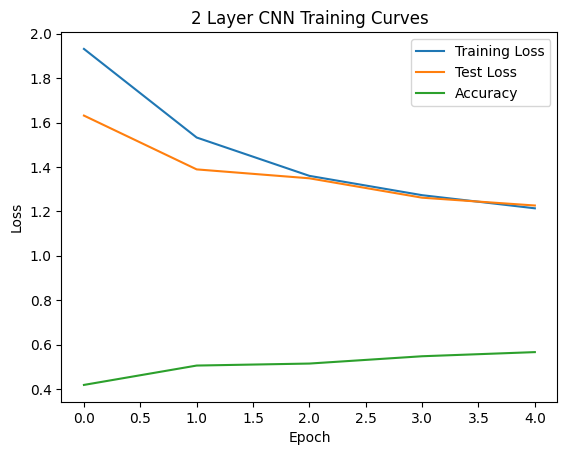

In [5]:
try:
    del train_loader
    del test_loader
    del model_1a
    del model_1b
    del resnet
    del train_loader_cuda
    del test_loader_cuda
except:
    pass

# Reset CUDA context
start = time.time()
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

gc.collect()


cifar10_train = datasets.CIFAR10(data_path, train=True, download=dl, transform=transform)
cifar10_test = datasets.CIFAR10(data_path, train=False, download=dl, transform=transform)

batch_size = int(2**11)
workers = 12
cpu_prefetch = 39
gpu_prefetch = 28

print('begin init train_loader')
train_loader = DataLoader(
    cifar10_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=workers,
    prefetch_factor=cpu_prefetch,
    pin_memory=True
)

X_batch = next(iter(train_loader))[0]
dtype_size = X_batch.element_size()
print(f"Batch Size: {X_batch.element_size() * X_batch.nelement() / 1024**2} MiB")


print('begin init fetcher')
train_loader_cuda = CudaDataPrefetcher(
    data_iterable = train_loader,
    device = torch.device('cuda'),
    num_prefetch_batches=gpu_prefetch
)
test_loader = DataLoader(cifar10_test, batch_size=len(cifar10_test), shuffle=True, num_workers=workers, pin_memory=True, prefetch_factor=1)
test_loader_cuda = CudaDataPrefetcher(
    data_iterable = test_loader,
    device = torch.device('cuda'),
    num_prefetch_batches=1
)

model_1a = ConvImageClassifier(
    input_dim = 32,
    conv_layers=[32, 64],
    fc_layers=[32, 10],
    activation=nn.ReLU
).to(device=device)
 
print(model_1a.stack)

model_1a.train_model(
    epochs=200,
    train_loader=train_loader_cuda,
    train_len=len(train_loader),
    test_loader=test_loader_cuda,
    test_len=len(test_loader),
    test_size = len(cifar10_test),
    loss_fn=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam,
    optimizer_kwargs={'lr': 8e-3, 'weight_decay': 1e-2},
    print_epoch=1,
    header_epoch=15
)

del train_loader
del test_loader

model_1a.plot_training("2 Layer CNN Training Curves")


begin init train_loader
Batch Size: 24.0 MiB
begin init fetcher
Sequential(
  (conv0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (activation0): ReLU()
  (maxpool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (activation1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (activation2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc0): Linear(in_features=2048, out_features=32, bias=True)
  (activation_fc1): Tanh()
  (fc1): Linear(in_features=32, out_features=10, bias=True)
)
Training ConvImageClassifier

-------------------------------------------------------------------------------------------------------------------------------

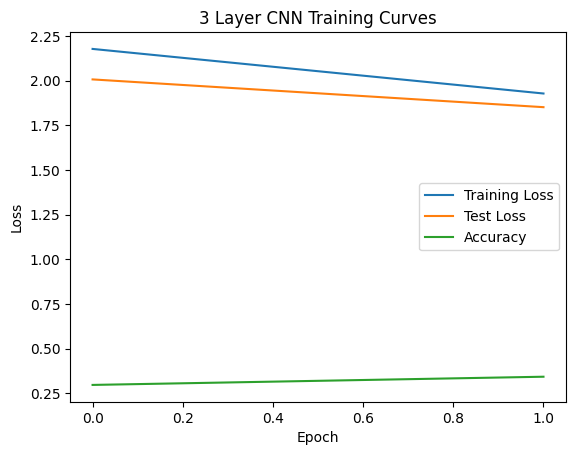

In [7]:
try:
    del train_loader
    del test_loader
    del model_1a
    del model_1b
    del resnet
    del train_loader_cuda
    del test_loader_cuda
except:
    pass

# Reset CUDA context
start = time.time()
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

gc.collect()


cifar10_train = datasets.CIFAR10(data_path, train=True, download=dl, transform=transform)
cifar10_test = datasets.CIFAR10(data_path, train=False, download=dl, transform=transform)

batch_size = int(2**11)
workers = 12
cpu_prefetch = 39
gpu_prefetch = 28

print('begin init train_loader')
train_loader = DataLoader(
    cifar10_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=workers,
    prefetch_factor=cpu_prefetch,
    pin_memory=True
)

X_batch = next(iter(train_loader))[0]
dtype_size = X_batch.element_size()
print(f"Batch Size: {X_batch.element_size() * X_batch.nelement() / 1024**2} MiB")


print('begin init fetcher')
train_loader_cuda = CudaDataPrefetcher(
    data_iterable = train_loader,
    device = torch.device('cuda'),
    num_prefetch_batches=gpu_prefetch
)
test_loader = DataLoader(cifar10_test, batch_size=len(cifar10_test), shuffle=True, num_workers=workers, pin_memory=True, prefetch_factor=1)
test_loader_cuda = CudaDataPrefetcher(
    data_iterable = test_loader,
    device = torch.device('cuda'),
    num_prefetch_batches=1
)

model_1b = ConvImageClassifier(
    input_dim = 32,
    conv_layers=[32, 64, 128],
    fc_layers=[32, 10],
    activation=nn.ReLU
).to(device=device)
 
print(model_1b.stack)

model_1b.train_model(
    epochs=200,
    train_loader=train_loader_cuda,
    train_len=len(train_loader),
    test_loader=test_loader_cuda,
    test_len=len(test_loader),
    test_size = len(cifar10_test),
    optimizer = torch.optim.Adam,
    optimizer_kwargs={'lr': 3e-4, 'weight_decay': 1e-2}, #Increase alpha to 2 next time
    loss_fn=nn.CrossEntropyLoss(),
    print_epoch=1
)
del train_loader
del test_loader
model_1b.plot_training("3 Layer CNN Training Curves")


In [7]:
#after last bn but before last weight

class ResBlock(nn.Module):
    def __init__(self, in_chans, out_chans, nonlinearity = 'relu', stride=1, dropout = 0.4):
        super().__init__()
        self.conv1 = nn.Conv2d(in_chans, out_chans, kernel_size=3, padding=1, bias=False, stride=stride)
        self.batch_norm1 = nn.BatchNorm2d(num_features=out_chans)
        self.conv2 = nn.Conv2d(out_chans, out_chans, kernel_size=3, padding=1, bias=False, stride=stride)
        self.batch_norm2 = nn.BatchNorm2d(num_features=out_chans)
        self.dropout = nn.Dropout(dropout)
        self.shortcut = nn.Conv2d(in_chans, out_chans, kernel_size=1, stride=1, bias=False) if in_chans != out_chans else nn.Identity()
        
        
        torch.nn.init.kaiming_normal_(self.conv1.weight, nonlinearity=nonlinearity)
        torch.nn.init.constant_(self.batch_norm1.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm1.bias)
        torch.nn.init.kaiming_normal_(self.conv2.weight, nonlinearity=nonlinearity)
        torch.nn.init.zeros_(self.batch_norm2.bias)
    def forward(self, x):
        out = self.batch_norm1(x)
        out = F.relu(out)
        out = self.conv1(out)
        out = self.batch_norm2(out)
        out = F.relu(out)
        out = self.dropout(out)
        out = self.conv2(out)
        out += self.shortcut(x)
        return out
class ResNet(Classifier):
    def __init__(self, input_dim = 32, n_blocks = 10, conv_channels = [32,16], fc_channels = [32, 10], dropout_p=0.4, dropout_h=0.4, nonlinearity='relu'):
        super().__init__()
        
        # Add initial convolutions
        self.h1 = nn.Sequential()
        for i in range(len(conv_channels)):
            self.h1.add_module(
                name=f'conv{i}',
                module=nn.Conv2d(
                    in_channels = 3 if i == 0 else conv_channels[i-1],
                    out_channels=conv_channels[i],
                    kernel_size=3,
                    padding=1
                )
            )
            self.h1.add_module(
                name=f'activation{i}',
                module=nn.ReLU()
            )
        self.h1.add_module(
            name=f'maxpool',
            module=nn.MaxPool2d(2)
        )
        #output of h1 before maxpool is 16 32x32 images. After maxpool, 16 16x16 images
# h1_in: torch.Size([1024, 3, 32, 32])
# res_block_in: torch.Size([1024, 16, 16, 16])
# h2_in: torch.Size([1024, 64])
        #Add Resblocks
        res_block_in = conv_channels[0]//2
        self.resblocks = nn.Sequential(
            *[
                ResBlock(
                    in_chans=conv_channels[-1],
                    out_chans=conv_channels[-1],
                    nonlinearity=nonlinearity,
                    dropout=dropout_p
                ) for _ in range(n_blocks)
            ]
        )

        
        #output of resblocks is 16 16x16 images
        
        # Add final layers
        self.h2 = nn.Sequential()
        self.h2.add_module(
            name='final_batch_norm',
            module=nn.BatchNorm2d(
                num_features=conv_channels[-1]
            )
        )
        self.h2.add_module(
            name='final_relu',
            module=nn.ReLU()
        )
        self.h2.add_module(
            name = 'dropout_head',
            module=nn.Dropout(dropout_h)
        )
        self.h2.add_module(
            name = 'gap',
            module=nn.AvgPool2d(2)
        )
        self.h2.add_module(
            name = 'flatten',
            module=nn.Flatten()
        )
        
        #output is 16 8x8 images
        #   16 comes from conv_channels[-1]
        #   8x8 comes from input_dim // 4
        fc_in = conv_channels[-1] * (input_dim//4)**2
        
        for i in range(len(fc_channels)):
            
            self.h2.add_module(
                name=f'fc{i}',
                module=nn.Linear(
                    in_features=fc_in if i == 0 else fc_channels[i-1],
                    out_features=fc_channels[i]
                )
            )
            if i < len(fc_channels) - 1:
                self.h2.add_module(
                    name = f'fc_activation{i}',
                    module=nn.ReLU()
                )
        self.h2.add_module('softmax', nn.Softmax(dim=1))
    def forward(self, x):
        #print(f"h1_in: {x.shape}")
        out = self.h1(x)
        #print(f"res_block_in: {out.shape}")
        out = self.resblocks(out)
        #print(f"h2_in: {out.shape}")
        out = self.h2(out)
        return out


begin init train_loader
Batch Size: 24.0 MiB
begin init fetcher
Init time: 3.92 seconds
Training ResNet

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|       Epoch        |   Epoch Time (s)   |   Training Loss    |     Test Loss      |    Overfit (%)     |    Accuracy (%)    |   Δ Accuracy (%)   |  GPU Memory (GiB)  |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|         0          |      7.778244      |      2.274575      |      2.330708      |      2.467858      |      0.100000      |      0.000000      |      4.617005      |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|         1          |      5.951306      |  

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

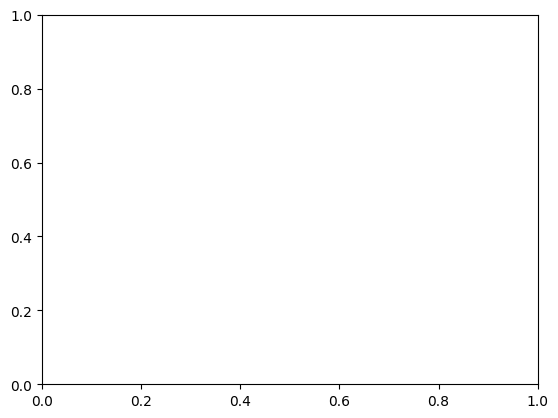

In [8]:
from torch.profiler import profile, record_function, ProfilerActivity
try:
    del train_loader
    del test_loader
    del model_1a
    del model_1b
    del resnet
    del train_loader_cuda
    del test_loader_cuda
except:
    pass

# Reset CUDA context
start = time.time()
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

gc.collect()


cifar10_train = datasets.CIFAR10(data_path, train=True, download=dl, transform=transform)
cifar10_test = datasets.CIFAR10(data_path, train=False, download=dl, transform=transform)

batch_size = int(2**11)
workers = 12
cpu_prefetch = 39
gpu_prefetch = 28

print('begin init train_loader')
train_loader = DataLoader(
    cifar10_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=workers,
    prefetch_factor=cpu_prefetch,
    pin_memory=True
)

X_batch = next(iter(train_loader))[0]
dtype_size = X_batch.element_size()
print(f"Batch Size: {X_batch.element_size() * X_batch.nelement() / 1024**2} MiB")


print('begin init fetcher')
train_loader_cuda = CudaDataPrefetcher(
    data_iterable = train_loader,
    device = torch.device('cuda'),
    num_prefetch_batches=gpu_prefetch
)
test_loader = DataLoader(cifar10_test, batch_size=len(cifar10_test), shuffle=True, num_workers=workers, pin_memory=True, prefetch_factor=1)
test_loader_cuda = CudaDataPrefetcher(
    data_iterable = test_loader,
    device = torch.device('cuda'),
    num_prefetch_batches=1
)

resnet = ResNet(
    input_dim = 32,
    conv_channels=[16,16],
    n_blocks = 10,
    fc_channels=[16,10],
    dropout_h = 0.6,
    dropout_p = 0.4
).to(device=device)
print(f"Init time: {(time.time() - start):.2f} seconds")

resnet.train_model(
    epochs=200,
    train_loader=train_loader_cuda,
    train_len=len(train_loader),
    test_loader=test_loader_cuda,
    test_len=len(test_loader),
    test_size=len(cifar10_test),
    loss_fn=nn.CrossEntropyLoss(),
    optimizer = torch.optim.Adam,
    optimizer_kwargs={'lr': 1e-3, 'weight_decay': 3e-3},
    print_epoch=1
)


resnet.plot_training("ResNet Training Curves")



In [ ]:
!gclouddd compute instances stop $HOSTNAME --zone=me-west1-c